In [43]:
import datetime
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string

In [23]:
tweets = pd.read_csv("./data/tweets_all.csv", encoding="latin1")

In [24]:
min_lat = tweets.LATITUDE.min()
min_long = tweets.LONGITUDE.min()

In [25]:
lat_range = tweets.LATITUDE.max() - tweets.LATITUDE.min()
long_range = tweets.LONGITUDE.max() - tweets.LONGITUDE.min()

lat_bin_size = lat_range/9
long_bin_size= long_range/9

In [26]:
tweets["Space"] = tweets.LONGITUDE.apply(lambda long: (((long - min_long)//long_bin_size)+1))
tweets["Row"] = tweets.LATITUDE.apply(lambda lat: (9-((lat - min_lat)//lat_bin_size)+1))

In [27]:
tweets["Space"] = tweets["Space"].apply(lambda l: int(l))
tweets["Row"] = tweets["Row"].apply(lambda l: int(l))

In [28]:
tweets = tweets[~((tweets["Row"] == 1) & (tweets["Space"] == 8 ))]
tweets = tweets[~((tweets["Row"] == 3) & (tweets["Space"] == 10 ))]

In [29]:
tweets["One"] = 1

In [30]:
def parse_tweets(tweet):

    tweet = re.sub('@[^\s]+','',tweet).strip()
    tweet = re.sub('#[^\s]+','',tweet).strip()
    tweet = re.sub(r'https?:\/\/.*[\r\n]*','',tweet).strip()
    tweet = " ".join(re.findall("[a-zA-Z]+", tweet))
    
    return tweet

In [31]:
tweets["parsed_tweets"] = tweets.MESSAGETEXT.apply(lambda tweet: parse_tweets(tweet))

In [32]:
# need to get pos tag
class StemmerTokenizer(object):

    def __init__(self):
        self.stemmer = PorterStemmer()
        
    def __call__(self, doc):
        is_noun = lambda pos: pos[:2] == 'NN'
        doc = " ".join(re.findall("[a-zA-Z]+", doc))
        tokenized = nltk.word_tokenize(doc)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        return [self.stemmer.stem(t) for t in word_tokenize(doc)]

In [33]:
tweets["datetime"] = pd.to_datetime(tweets.MESSAGEDATE)

In [34]:
tweets["datetime_to_nearest_hour"] = tweets.datetime.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour))

In [35]:
tweets.head()

,id,Name,X,Y,LONGITUDE,LATITUDE,MESSAGEDATE,USERID,USERSCREENNAME,MESSAGETEXT,LOCATION,HASHTAGS,ISRETWEET,Space,Row,One,parsed_tweets,datetime,datetime_to_nearest_hour
0,550226818624942080,NaN,-0.262150,51.391407,-0.262150,51.391407,31/12/2014 09:47:50,113918054,12Elbestreet,@julieo25 Not yet got tics for Liverpool waiti...,Kingston upon Thames; London,NaN,0,3,8,1,Not yet got tics for Liverpool waiting till Fr...,2014-12-31 09:47:50,2014-12-31 09:00:00
1,550226823314178048,NaN,-0.149466,51.492560,-0.149466,51.492561,31/12/2014 09:47:52,465989904,alice_foster_95,So. Many. Accents #alicesadventureswithmegabus,London; England,alicesadventureswithmegabus,0,4,6,1,So Many Accents,2014-12-31 09:47:52,2014-12-31 09:00:00
2,550226827944660992,NaN,-0.014891,51.354042,-0.014891,51.354042,31/12/2014 09:47:53,55872342,MissGee_Pee,If it doesn't make you happy by December 31st....,New Addington; London,NaN,0,6,9,1,If it doesn t make you happy by December st le...,2014-12-31 09:47:53,2014-12-31 09:00:00
3,550226837537058816,NaN,0.006698,51.532020,0.006698,51.532021,31/12/2014 09:47:55,147266450,vinita_ramtri,@westfieldstrat thanks; and are you open tomor...,Stratford; London,NaN,0,6,5,1,thanks and are you open tomorrow at all,2014-12-31 09:47:55,2014-12-31 09:00:00
4,550227214227505152,NaN,0.214417,51.582535,0.214417,51.582535,31/12/2014 09:49:25,518928608,CallumGordon7,@WestHam_Central but he is,Romford; London,NaN,0,8,4,1,but he is,2014-12-31 09:49:25,2014-12-31 09:00:00


In [15]:
# data = tweets[["id", "Space", "Row", "One", "parsed_tweets", "datetime", "datetime_to_nearest_hour"]]
# data.head()

,id,Space,Row,One,parsed_tweets,datetime,datetime_to_nearest_hour
0,550226818624942080,3,8,1,Not yet got tics for Liverpool waiting till Fr...,2014-12-31 09:47:50,2014-12-31 09:00:00
1,550226823314178048,4,6,1,So Many Accents,2014-12-31 09:47:52,2014-12-31 09:00:00
2,550226827944660992,6,9,1,If it doesn t make you happy by December st le...,2014-12-31 09:47:53,2014-12-31 09:00:00
3,550226837537058816,6,5,1,thanks and are you open tomorrow at all,2014-12-31 09:47:55,2014-12-31 09:00:00
4,550227214227505152,8,4,1,but he is,2014-12-31 09:49:25,2014-12-31 09:00:00


In [36]:
tweets["Ref"] = tweets["Space"] + (tweets["Row"] - 1) * 10

In [37]:
tweets.head()

,id,Name,X,Y,LONGITUDE,LATITUDE,MESSAGEDATE,USERID,USERSCREENNAME,MESSAGETEXT,LOCATION,HASHTAGS,ISRETWEET,Space,Row,One,parsed_tweets,datetime,datetime_to_nearest_hour,Ref
0,550226818624942080,NaN,-0.262150,51.391407,-0.262150,51.391407,31/12/2014 09:47:50,113918054,12Elbestreet,@julieo25 Not yet got tics for Liverpool waiti...,Kingston upon Thames; London,NaN,0,3,8,1,Not yet got tics for Liverpool waiting till Fr...,2014-12-31 09:47:50,2014-12-31 09:00:00,73
1,550226823314178048,NaN,-0.149466,51.492560,-0.149466,51.492561,31/12/2014 09:47:52,465989904,alice_foster_95,So. Many. Accents #alicesadventureswithmegabus,London; England,alicesadventureswithmegabus,0,4,6,1,So Many Accents,2014-12-31 09:47:52,2014-12-31 09:00:00,54
2,550226827944660992,NaN,-0.014891,51.354042,-0.014891,51.354042,31/12/2014 09:47:53,55872342,MissGee_Pee,If it doesn't make you happy by December 31st....,New Addington; London,NaN,0,6,9,1,If it doesn t make you happy by December st le...,2014-12-31 09:47:53,2014-12-31 09:00:00,86
3,550226837537058816,NaN,0.006698,51.532020,0.006698,51.532021,31/12/2014 09:47:55,147266450,vinita_ramtri,@westfieldstrat thanks; and are you open tomor...,Stratford; London,NaN,0,6,5,1,thanks and are you open tomorrow at all,2014-12-31 09:47:55,2014-12-31 09:00:00,46
4,550227214227505152,NaN,0.214417,51.582535,0.214417,51.582535,31/12/2014 09:49:25,518928608,CallumGordon7,@WestHam_Central but he is,Romford; London,NaN,0,8,4,1,but he is,2014-12-31 09:49:25,2014-12-31 09:00:00,38


In [38]:
ref_to_cluster = pd.read_csv("./data/ref_to_cluster.csv")

In [39]:
ref_to_cluster.head()

,Ref,Cluster
0,11,6
1,21,1
2,31,1
3,41,5
4,51,5


In [40]:
tweets = tweets.merge(ref_to_cluster, left_on='Ref', right_on='Ref', how='outer')

In [41]:
tweets.head()

,id,Name,X,Y,LONGITUDE,LATITUDE,MESSAGEDATE,USERID,USERSCREENNAME,MESSAGETEXT,...,HASHTAGS,ISRETWEET,Space,Row,One,parsed_tweets,datetime,datetime_to_nearest_hour,Ref,Cluster
0,550226818624942080,NaN,-0.262150,51.391407,-0.262150,51.391407,31/12/2014 09:47:50,113918054,12Elbestreet,@julieo25 Not yet got tics for Liverpool waiti...,...,NaN,0,3,8,1,Not yet got tics for Liverpool waiting till Fr...,2014-12-31 09:47:50,2014-12-31 09:00:00,73,2
1,550212608746606594,NaN,-0.261681,51.391760,-0.261681,51.391762,31/12/2014 08:51:23,113918054,12Elbestreet,One of the greatest singers of all time good m...,...,NaN,0,3,8,1,One of the greatest singers of all time good m...,2014-12-31 08:51:23,2014-12-31 08:00:00,73,2
2,550218811904114688,NaN,-0.298933,51.420210,-0.298933,51.420212,31/12/2014 09:16:01,2463405963,mrsclaireismail,@theshores124 We were planning to go down to B...,...,NaN,0,3,8,1,We were planning to go down to Bournemouth Fri...,2014-12-31 09:16:01,2014-12-31 09:00:00,73,2
3,550225718060519424,NaN,-0.293391,51.416702,-0.293391,51.416702,31/12/2014 09:43:28,450719269,manda10110,@joemcelderry91 Wishing you Health; Love and ...,...,NaN,0,3,8,1,Wishing you Health Love and Laughter for and s...,2014-12-31 09:43:28,2014-12-31 09:00:00,73,2
4,550226427069865984,NaN,-0.261647,51.391495,-0.261647,51.391495,31/12/2014 09:46:17,113918054,12Elbestreet,@julieo25 the secret is safe with me good job ...,...,NaN,0,3,8,1,the secret is safe with me good job he is not ...,2014-12-31 09:46:17,2014-12-31 09:00:00,73,2


In [42]:
tweets.groupby("Cluster").agg("count")

,id,Name,X,Y,LONGITUDE,LATITUDE,MESSAGEDATE,USERID,USERSCREENNAME,MESSAGETEXT,LOCATION,HASHTAGS,ISRETWEET,Space,Row,One,parsed_tweets,datetime,datetime_to_nearest_hour,Ref
Cluster,,,,,,,,,,,,,,,,,,,,
0,25035,0,25035,25035,25035,25035,25035,25035,25035,25035,25035,5021,25035,25035,25035,25035,25035,25035,25035,25035
1,8091,0,8091,8091,8091,8091,8091,8091,8091,8091,8091,897,8091,8091,8091,8091,8091,8091,8091,8091
2,31118,0,31118,31118,31118,31118,31118,31118,31118,31118,31118,5720,31118,31118,31118,31118,31118,31118,31118,31118
3,105,0,105,105,105,105,105,105,105,105,105,21,105,105,105,105,105,105,105,105
4,611,0,611,611,611,611,611,611,611,611,611,76,611,611,611,611,611,611,611,611
5,38472,0,38472,38472,38472,38472,38472,38472,38472,38472,38472,4612,38472,38472,38472,38472,38472,38472,38472,38472
6,16416,0,16416,16416,16416,16416,16416,16416,16416,16416,16416,1701,16416,16416,16416,16416,16416,16416,16416,16416


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

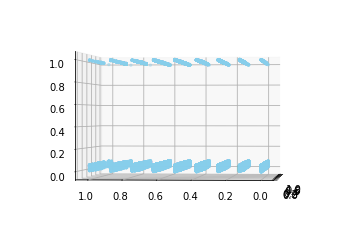

In [59]:
cluster = tweets[tweets["Cluster"] == 6]
cluster["ts"] = cluster.datetime.values.astype(np.int64) // 10 ** 9

cluster["norm_space"] = (cluster.Space - cluster.Space.min()) / (cluster.Space.max() - cluster.Space.min())
cluster["norm_row"] = (cluster.Row - cluster.Row.min()) / (cluster.Row.max() - cluster.Row.min())
cluster["norm_ts"] = (cluster.ts - cluster.ts.min()) / (cluster.ts.max() - cluster.ts.min())

x = cluster_2["norm_space"]
y = cluster_2["norm_row"]
z = cluster_2["norm_ts"]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='skyblue', s=6)
ax.view_init(0, 185)
plt.show()